Author: Wenguang Cai

In [185]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
import urllib
from sqlalchemy import create_engine
from IPython.display import display, clear_output

# Data Preparation

In [3]:
data = pd.read_csv('attributes.csv', index_col=0)

In [4]:
data = data.sort_values(by='report_period')
X = data.iloc[:,2:-1]
y = data.iloc[:,-1]

train = list(X.index[data['report_period']<20171231])
valid = list(X.index[data['report_period']==20171231])
test = list(X.index[data['report_period']>20171231])

np.random.seed(0)
np.random.shuffle(train)
np.random.shuffle(valid)
np.random.shuffle(test)

acc = data.loc[train].loc[:,['acc_firm','FRAUD']]
acc_rank = acc.groupby('acc_firm').describe()['FRAUD'].sort_values(by='mean', ascending=False)
bad_acc = acc_rank.index[:10]
X['bad_acc'] = X['acc_firm'].apply(lambda x: x in bad_acc)
ind = data.loc[train].loc[:,['industry','FRAUD']]
ind_rank = ind.groupby('industry').describe()['FRAUD'].sort_values(by='mean', ascending=False)
bad_ind = ind_rank.index[:10]
X['bad_ind'] = X['industry'].apply(lambda x: x in bad_ind)
X=X.drop(columns =['acc_firm','industry','NET_CASH_FLOWS_FNC_ACTyoy'])

X = X.replace(np.inf,np.nan)
X = X.replace(-np.inf,np.nan)
X = X.fillna(X.mean())

X_train = X.loc[train,]
X_valid = X.loc[valid,]
X_test = X.loc[test,]
y_train = y.loc[train,]
y_valid = y.loc[valid,]
y_test = y.loc[test,]
X_train_valid = X.loc[list(valid)+list(valid)]
y_train_valid = y.loc[list(valid)+list(valid)]

In [6]:
data[data['FRAUD']==1].groupby('report_period').describe()

TOT_LIAB                                            \
                 count          mean           std           min   
report_period                                                      
20141231          23.0  4.752894e+09  1.167848e+10  9.536904e+07   
20151231          17.0  2.092370e+09  2.096935e+09  4.427383e+06   
20161231          27.0  5.122936e+09  7.251772e+09  1.143819e+08   
20171231          44.0  5.186781e+09  6.576741e+09  5.105575e+07   
20181231          32.0  4.467506e+09  6.556868e+09  4.612771e+07   
20191231           4.0  1.279391e+09  3.376296e+08  9.666740e+08   

                                                                       \
                        25%           50%           75%           max   
report_period                                                           
20141231       5.782611e+08  9.288909e+08  3.235162e+09  5.548174e+10   
20151231       1.911639e+08  1.804020e+09  2.991881e+09  7.248570e+09   
20161231       8.727523e+08  2.533321e+09  5.365919e+09  2.879726e+10   
20171231       6.984658e+08  2.915345e+09  6.083749e+09  2.783560e+10   
20181231       1.172956e+09  2.442526e+09  3.834375e+09  2.926126e+10   
20191231       1.049117e+09  1.213205e+09  1.443480e+09  1.724481e+09   

              TOT_ASSETS                ... holder_trade_count       FRAUD  \
                   count          mean  ...                75%   max count   
report_period                           ...                                  
20141231            23.0  6.718930e+09  ...               1.00  17.0  23.0   
20151231            17.0  4.135218e+09  ...               4.00  11.0  17.0   
20161231            27.0  8.966536e+09  ...               5.50  21.0  27.0   
20171231            44.0  9.155877e+09  ...               7.25  60.0  44.0   
20181231            32.0  7.767222e+09  ...               8.00  53.0  32.0   
20191231             4.0  3.719452e+09  ...               5.75  23.0   4.0   

                                                  
              mean  std  min  25%  50%  75%  max  
report_period                                     
20141231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  
20151231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  
20161231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  
20171231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  
20181231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  
20191231       1.0  0.0  1.0  1.0  1.0  1.0  1.0  

[6 rows x 808 columns]

# Training and Evaluation

In [9]:
def confusion_matrix_function(tot_validation_y, tot_predicted_y, normalize = 'true'):
    conf_matrix = confusion_matrix(tot_validation_y, tot_predicted_y, normalize =normalize)
    
    conf_matrix_table = pd.DataFrame(data = conf_matrix).transpose()
    conf_matrix_table.index   = ['Predicted Non-default', 'Predicted Default']
    conf_matrix_table.columns = ['Actual Non-default'   , 'Actual Default'   ]
    
    return conf_matrix_table

In [186]:

def do_roc_auc(train_x_roc, train_y_roc, validation_x_roc, validation_y_roc,
               classifier=None, roc_frequency=50, fit=True, predict_proba='none', verbose=False):

    if predict_proba=='none':
        # Fit model on training set
        if fit==True:
            classifier.fit(train_x_roc, train_y_roc)
        # Test on test set, get prob
        predict_proba = classifier.predict_proba(validation_x_roc) # prob of 0, prob of 1
    prob_df = pd.DataFrame(data = predict_proba, columns = ['0_prob','1_prob'])
    
    false_positive_list, true_positive_list, threshold_set = roc_curve(validation_y_roc, prob_df['1_prob'])

    if verbose:
        # print(true_positive_list)
        # print(false_positive_list)
        # Compute AUC
        auc_score = roc_auc_score(validation_y_roc, prob_df['1_prob'])
        # Plot ROC-AUC curve
        plt.figure()
        lw = 2
        plt.plot(false_positive_list, true_positive_list, color='darkorange',
                 lw=lw, label='ROC curve (AUC = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    tp_fp_diff = np.array(true_positive_list) - np.array(false_positive_list)
    best_thre = threshold_set[tp_fp_diff.argmax()]
    print('best threshold: ', best_thre)
    return best_thre

In [187]:
def evaluate(clf):
    thre = do_roc_auc(classifier=clf,
           train_x_roc=X_train, train_y_roc=y_train, 
           validation_x_roc=X_valid, validation_y_roc=y_valid)
    do_roc_auc(classifier=clf,
           train_x_roc=X_train_valid, train_y_roc=y_train_valid, 
           validation_x_roc=X_test, validation_y_roc=y_test, verbose = True)
    predict = clf.predict_proba(X_test)
    predict_df = pd.DataFrame(data = predict, columns = ['0_prob','1_prob'])
    display(confusion_matrix_function(y_test, predict_df['1_prob'] > thre, normalize =None))
    return thre

## Adaboost

In [157]:
# adaboost
ab_parameters = {'learning_rate':([0.5,0.6,0.7,0.8,0.9]), 'n_estimators':[150,175,200,225,250]}
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
                        random_state=0)
ab_gs = GridSearchCV(estimator=ab, param_grid=ab_parameters, scoring='roc_auc', 
                     n_jobs=-1, verbose=1)
ab_gs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight='balanced',
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_lea

In [164]:
ab_gs.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                    

best threshold:  0.49105393891406623


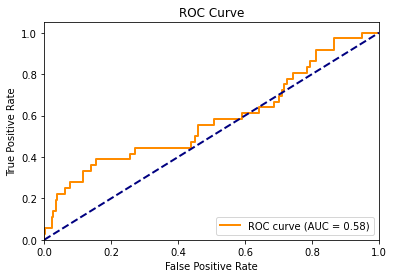

best threshold:  0.4852453936771883


,Actual Non-default,Actual Default
Predicted Non-default,6489,27
Predicted Default,523,9


0.49105393891406623

In [188]:
evaluate(ab_gs.best_estimator_)

## Random Forest

In [167]:
# random forest
parameters = {'max_depth':([1,2,3]), 'min_samples_leaf':[0.03,0.04,0.05]}
rf = RandomForestClassifier(class_weight='balanced', random_state=0, n_estimators=200)
rf_gs = GridSearchCV(estimator=rf, param_grid=parameters, scoring='roc_auc',
                 n_jobs=-1, verbose=2)
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=0,
                          

In [168]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.03, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

best threshold:  0.4787083269914108


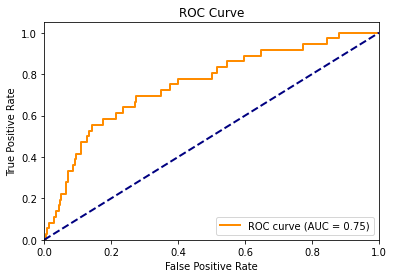

best threshold:  0.3967899199506043


,Actual Non-default,Actual Default
Predicted Non-default,6074,18
Predicted Default,938,18


In [189]:
rf_thre = evaluate(rf_gs.best_estimator_)

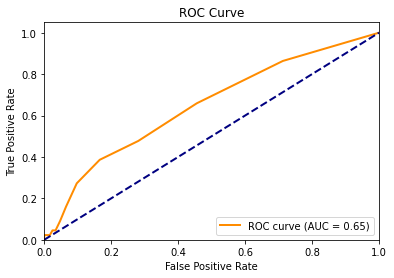

best threshold:  0.02


0.02

In [230]:
do_roc_auc(classifier=rf,
           train_x_roc=X_train, train_y_roc=y_train,
           validation_x_roc=X_valid, validation_y_roc=y_valid, fit=True, verbose = True)

In [170]:
# feature importance
fi = pd.DataFrame(data={
    'feature':X.columns,
    'importance':rf_gs.best_estimator_.feature_importances_})
fi = fi.sort_values(by='importance',ascending=False)
fi.iloc[:10]

,feature,importance
32,LESS_NON_OPER_EXPyoy,0.062487
64,rev_to_pro,0.053156
71,otherrev_to_curasset,0.042947
95,std_240d,0.040602
65,outrev_to_pro,0.035114
66,acctrev_ratio,0.033132
68,money_to_pro,0.032202
70,prepay_to_curasset,0.027952
79,salemaoli_ratio_yoy_diff,0.026180
55,maoli_ratio,0.025463


In [133]:
for i in range(5):
    tree.export_graphviz(rf_gs.best_estimator_.estimators_[i],
                         out_file="tree%d.dot"%i,
                         feature_names = X.columns, 
                         # class_names=cn,
                         filled = True)

In [134]:
!dot -Tpng tree0.dot -o tree0.png
!dot -Tpng tree1.dot -o tree1.png
!dot -Tpng tree2.dot -o tree2.png
!dot -Tpng tree3.dot -o tree3.png
!dot -Tpng tree4.dot -o tree4.png

## SVM

In [173]:
# svm
parameters = {'svc__C':np.logspace(1.5,3,5),'svc__degree':[2,3,4]}
svc = make_pipeline(StandardScaler(), 
                    SVC(class_weight='balanced', gamma='auto', random_state=0, probability=True))
svc_gs = GridSearchCV(svc, parameters, n_jobs=-1, verbose=2, scoring='roc_auc')
svc_gs.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   50.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200,
                                            class_weight='balanced', coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto',
                                            kernel='rbf', max_iter=-1,
                                            probability=True, random_state=0,
                                            shrinking=True, tol=0.001,
                              

In [171]:
svc_gs.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=421.6965034285823, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=2, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=0, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

best threshold:  0.006006893354505292


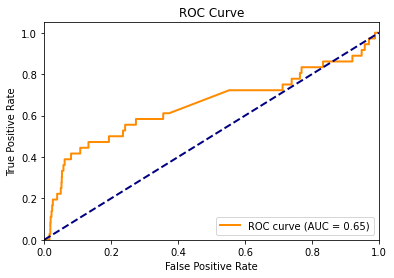

best threshold:  0.0018926271213141042


,Actual Non-default,Actual Default
Predicted Non-default,6925,36
Predicted Default,87,0


0.006006893354505292

In [190]:
evaluate(svc_gs.best_estimator_)

## Neural Network

In [20]:
#nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [174]:
std = StandardScaler()
std.fit(X_train)
X_train_nn = pd.DataFrame(data = std.transform(X_train), columns=X_train.columns, index = X_train.index)
X_valid_nn = pd.DataFrame(data = std.transform(X_valid), columns=X_train.columns, index = X_valid.index)
X_train_valid_nn = pd.DataFrame(data = std.transform(X_train_valid), columns=X_train.columns, index = X_train_valid.index)
X_test_nn = pd.DataFrame(data = std.transform(X_test), columns=X_train.columns, index = X_test.index)

In [224]:
lamda = 1
epochs = 200
p = 0.2
model = Sequential()
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=lamda), 
                kernel_initializer=he_normal(),
                input_dim=X_train.shape[1]))
model.add(Dropout(p))
model.add(Dense(4, activation='relu',
                    kernel_regularizer=l2(l=lamda), 
                kernel_initializer=he_normal()))
model.add(Dense(1, activation='sigmoid',
                    kernel_initializer=he_normal()))

initial_learning_rate = 0.008
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True)

model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule,
                                beta_1=0.9, beta_2=0.95),
                  metrics=[keras.metrics.AUC(name='auc')])

history = model.fit(X_train_nn, y_train,
                    validation_data = (X_valid_nn.to_numpy(), y_valid.to_numpy()),
                     epochs=epochs, batch_size=3000, shuffle=True,
                     verbose=2,class_weight= {0:0.01,1:1.18})

Train on 7434 samples, validate on 3077 samples
Epoch 1/200
7434/7434 - 1s - loss: 22.3157 - auc: 0.5113 - val_loss: 21.2850 - val_auc: 0.5385
Epoch 2/200
7434/7434 - 0s - loss: 17.8924 - auc: 0.5300 - val_loss: 17.5088 - val_auc: 0.5383
Epoch 3/200
7434/7434 - 0s - loss: 14.3240 - auc: 0.4940 - val_loss: 14.4977 - val_auc: 0.5382
Epoch 4/200
7434/7434 - 0s - loss: 11.5028 - auc: 0.5988 - val_loss: 12.2682 - val_auc: 0.5379
Epoch 5/200
7434/7434 - 0s - loss: 9.4459 - auc: 0.5673 - val_loss: 10.5553 - val_auc: 0.5377
Epoch 6/200
7434/7434 - 0s - loss: 7.8298 - auc: 0.5866 - val_loss: 9.1916 - val_auc: 0.5377
Epoch 7/200
7434/7434 - 0s - loss: 6.5458 - auc: 0.6354 - val_loss: 20.0168 - val_auc: 0.4511
Epoch 8/200
7434/7434 - 0s - loss: 5.5812 - auc: 0.6147 - val_loss: 17.1067 - val_auc: 0.4618
Epoch 9/200
7434/7434 - 0s - loss: 4.8341 - auc: 0.6240 - val_loss: 16.4631 - val_auc: 0.4620
Epoch 10/200
7434/7434 - 0s - loss: 4.2220 - auc: 0.6465 - val_loss: 15.9325 - val_auc: 0.4625
Epoch 11

Epoch 86/200
7434/7434 - 0s - loss: 0.1668 - auc: 0.5493 - val_loss: 2.5046 - val_auc: 0.5392
Epoch 87/200
7434/7434 - 0s - loss: 0.1643 - auc: 0.5094 - val_loss: 12.2535 - val_auc: 0.4620
Epoch 88/200
7434/7434 - 0s - loss: 0.1620 - auc: 0.4981 - val_loss: 12.2513 - val_auc: 0.4624
Epoch 89/200
7434/7434 - 0s - loss: 0.1599 - auc: 0.4731 - val_loss: 0.3760 - val_auc: 0.5489
Epoch 90/200
7434/7434 - 0s - loss: 0.1578 - auc: 0.5166 - val_loss: 2.4958 - val_auc: 0.5400
Epoch 91/200
7434/7434 - 0s - loss: 0.1557 - auc: 0.5287 - val_loss: 12.2452 - val_auc: 0.4624
Epoch 92/200
7434/7434 - 0s - loss: 0.1538 - auc: 0.5483 - val_loss: 2.4921 - val_auc: 0.5395
Epoch 93/200
7434/7434 - 0s - loss: 0.1519 - auc: 0.5441 - val_loss: 0.3676 - val_auc: 0.5502
Epoch 94/200
7434/7434 - 0s - loss: 0.1501 - auc: 0.4550 - val_loss: 12.2398 - val_auc: 0.4630
Epoch 95/200
7434/7434 - 0s - loss: 0.1484 - auc: 0.4726 - val_loss: 12.2381 - val_auc: 0.4631
Epoch 96/200
7434/7434 - 0s - loss: 0.1468 - auc: 0.482

Epoch 173/200
7434/7434 - 0s - loss: 0.1050 - auc: 0.5256 - val_loss: 2.4446 - val_auc: 0.5398
Epoch 174/200
7434/7434 - 0s - loss: 0.1049 - auc: 0.5229 - val_loss: 2.4445 - val_auc: 0.5398
Epoch 175/200
7434/7434 - 0s - loss: 0.1048 - auc: 0.5109 - val_loss: 0.3217 - val_auc: 0.5500
Epoch 176/200
7434/7434 - 0s - loss: 0.1047 - auc: 0.5270 - val_loss: 0.3216 - val_auc: 0.5500
Epoch 177/200
7434/7434 - 0s - loss: 0.1046 - auc: 0.4920 - val_loss: 2.4442 - val_auc: 0.5398
Epoch 178/200
7434/7434 - 0s - loss: 0.1045 - auc: 0.5498 - val_loss: 2.4441 - val_auc: 0.5398
Epoch 179/200
7434/7434 - 0s - loss: 0.1044 - auc: 0.5472 - val_loss: 2.4440 - val_auc: 0.5397
Epoch 180/200
7434/7434 - 0s - loss: 0.1043 - auc: 0.4893 - val_loss: 0.3213 - val_auc: 0.5499
Epoch 181/200
7434/7434 - 0s - loss: 0.1042 - auc: 0.4436 - val_loss: 0.3212 - val_auc: 0.5500
Epoch 182/200
7434/7434 - 0s - loss: 0.1041 - auc: 0.5584 - val_loss: 2.4437 - val_auc: 0.5398
Epoch 183/200
7434/7434 - 0s - loss: 0.1040 - auc:

Text(0.5, 0, 'Epoch')

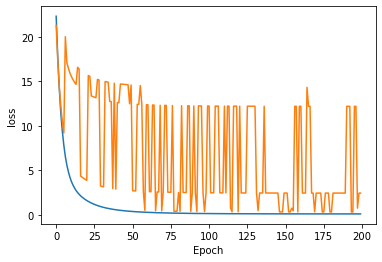

In [225]:
# visualise learning
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')

In [228]:
# Re-train using train and valid set together
model.fit(X_train_valid_nn, y_train_valid,
                     epochs=epochs, batch_size=3000, shuffle=True,
                     verbose=2,class_weight= {0:0.01,1:1.18})

Train on 6154 samples
Epoch 1/200
6154/6154 - 0s - loss: 0.3069 - auc: 0.5442
Epoch 2/200
6154/6154 - 0s - loss: 0.3014 - auc: 0.5545
Epoch 3/200
6154/6154 - 0s - loss: 0.3099 - auc: 0.5387
Epoch 4/200
6154/6154 - 0s - loss: 0.3101 - auc: 0.5373
Epoch 5/200
6154/6154 - 0s - loss: 0.3074 - auc: 0.5426
Epoch 6/200
6154/6154 - 0s - loss: 0.2980 - auc: 0.5621
Epoch 7/200
6154/6154 - 0s - loss: 0.3073 - auc: 0.5437
Epoch 8/200
6154/6154 - 0s - loss: 0.3015 - auc: 0.5549
Epoch 9/200
6154/6154 - 0s - loss: 0.3069 - auc: 0.5437
Epoch 10/200
6154/6154 - 0s - loss: 0.3105 - auc: 0.5363
Epoch 11/200
6154/6154 - 0s - loss: 0.3041 - auc: 0.5496
Epoch 12/200
6154/6154 - 0s - loss: 0.3040 - auc: 0.5494
Epoch 13/200
6154/6154 - 0s - loss: 0.3041 - auc: 0.5497
Epoch 14/200
6154/6154 - 0s - loss: 0.2980 - auc: 0.5628
Epoch 15/200
6154/6154 - 0s - loss: 0.3100 - auc: 0.5378
Epoch 16/200
6154/6154 - 0s - loss: 0.3128 - auc: 0.5323
Epoch 17/200
6154/6154 - 0s - loss: 0.3070 - auc: 0.5441
Epoch 18/200
6154/

Epoch 141/200
6154/6154 - 0s - loss: 0.3103 - auc: 0.5361
Epoch 142/200
6154/6154 - 0s - loss: 0.3098 - auc: 0.5370
Epoch 143/200
6154/6154 - 0s - loss: 0.2984 - auc: 0.5609
Epoch 144/200
6154/6154 - 0s - loss: 0.3040 - auc: 0.5503
Epoch 145/200
6154/6154 - 0s - loss: 0.3068 - auc: 0.5447
Epoch 146/200
6154/6154 - 0s - loss: 0.3074 - auc: 0.5420
Epoch 147/200
6154/6154 - 0s - loss: 0.3072 - auc: 0.5435
Epoch 148/200
6154/6154 - 0s - loss: 0.3042 - auc: 0.5492
Epoch 149/200
6154/6154 - 0s - loss: 0.3068 - auc: 0.5456
Epoch 150/200
6154/6154 - 0s - loss: 0.3038 - auc: 0.5513
Epoch 151/200
6154/6154 - 0s - loss: 0.3040 - auc: 0.5494
Epoch 152/200
6154/6154 - 0s - loss: 0.3043 - auc: 0.5483
Epoch 153/200
6154/6154 - 0s - loss: 0.3069 - auc: 0.5445
Epoch 154/200
6154/6154 - 0s - loss: 0.3007 - auc: 0.5571
Epoch 155/200
6154/6154 - 0s - loss: 0.2952 - auc: 0.5671
Epoch 156/200
6154/6154 - 0s - loss: 0.3034 - auc: 0.5528
Epoch 157/200
6154/6154 - 0s - loss: 0.3011 - auc: 0.5557
Epoch 158/200


/Users/Simon-CWG/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


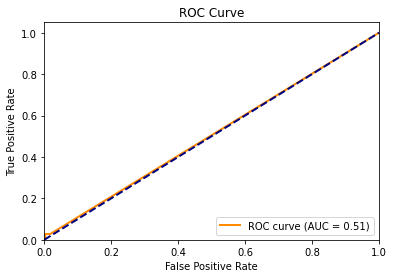

best threshold:  0.51830673


0.51830673

In [229]:
nn_predict_proba = np.concatenate(((1-model.predict(X_test_nn)), model.predict(X_test_nn)), axis=1)
do_roc_auc(classifier=model,
           train_x_roc=X_train_valid_nn, train_y_roc=y_train_valid, predict_proba = nn_predict_proba,
           validation_x_roc=X_test_nn, validation_y_roc=y_test, fit=False, verbose = True)

In [156]:
thre = 0.99205
predict = model.predict(X_test_nn)
predict = np.concatenate((predict,(1-predict)), axis=1)
predict_df = pd.DataFrame(data = predict, columns = ['0_prob','1_prob'])
display(confusion_matrix_function(y_test, predict_df['1_prob'] > thre, normalize =None))

,Actual Non-default,Actual Default
Predicted Non-default,1324,4
Predicted Default,5688,32


## Backtest as a strategy

In [67]:
# backtest
all_ts = pd.read_csv('all_stock_ts.csv', index_col=0, parse_dates=True)
all_ts.head()

,300735.SZ,600351.SH,002492.SZ,600860.SH,603726.SH,002911.SZ,688277.SH,300345.SZ,002438.SZ,002385.SZ,...,688028.SH,688300.SH,688001.SH,002395.SZ,600780.SH,601608.SH,300253.SZ,603012.SH,603517.SH,600029.SH
date,,,,,,,,,,,,,,,,,,,,,
2015-05-04,NaN,0.2950,-1.0402,0.2639,NaN,NaN,NaN,1.2223,-1.9839,0.2885,...,NaN,NaN,NaN,2.7833,8.7234,0.0000,-5.8655,-1.2853,NaN,-0.8349
2015-05-05,NaN,-5.2941,-3.0133,0.2632,NaN,NaN,NaN,-0.6038,-3.5678,-7.0695,...,NaN,NaN,NaN,-6.2863,-7.0450,0.0000,-3.9666,-2.1205,NaN,-6.6417
2015-05-06,NaN,-3.0280,0.0723,0.0875,NaN,NaN,NaN,3.0372,-2.8815,-2.0345,...,NaN,NaN,NaN,1.3932,-4.5263,0.0000,1.0445,-2.2805,NaN,-5.5110
2015-05-07,NaN,-4.2434,-7.2464,-5.4196,NaN,NaN,NaN,1.4001,0.9158,-0.8578,...,NaN,NaN,NaN,-6.7684,-6.9460,10.0775,5.2153,-3.9673,NaN,-6.5748
2015-05-08,NaN,4.2642,3.3594,1.7560,NaN,NaN,NaN,9.9927,3.2305,6.0565,...,NaN,NaN,NaN,5.7860,2.8436,10.0000,10.0030,3.7262,NaN,7.0375


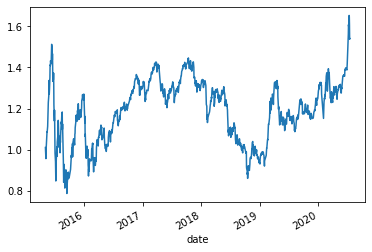

In [68]:
market_cum = (all_ts.mean(axis=1)/100+1).cumprod()
market_cum.plot()

In [190]:
def backtest(predict, strategy=0):
    backtest = all_ts.copy()
    all_year = []
    for i in range(predict.shape[0]):
        print(i)
        clear_output(wait=True)
        stockcode = predict.iloc[i,0]
        report_date = datetime.strptime(str(predict.iloc[i,1]),'%Y%m%d')
        report_yr = report_date.year
        if report_yr not in all_year:
            all_year.append(report_yr)
        startdate = date(report_yr+1,5,1) #次年5月1号开始
        enddate = startdate + timedelta(days = 547) #持仓1年半

        def select_date(date, startdate, enddate):
            if (date > startdate) & (date<enddate):
                return True
            else: return False

        date_range = all_ts.index[[select_date(date, startdate, enddate) for date in 
                                   list(all_ts.index)]]

        if strategy==0:
            backtest.loc[date_range,stockcode] = (backtest.loc[date_range,stockcode]) * strategy
    startdate = date(min(all_year)+1,5,1)
    enddate = date(max(all_year)+1,5,1) + timedelta(days=547)
    period = all_ts.index[[select_date(date, startdate, enddate) for date in 
                                   list(all_ts.index)]]
    
    market = all_ts.loc[period,].mean(axis=1)/100
    backtest = backtest.loc[period,].mean(axis=1)/100
    market_cum = (market+1).cumprod()
    backtest_cum = (backtest+1).cumprod()
    plot_df = pd.DataFrame(data={'strategy': backtest_cum, 'market': market_cum})
    plot_df.index = pd.to_datetime(plot_df.index)
    plot_df.plot()
    print(plot_df.iloc[-1])
    print('difference sharpe: ', (backtest - market).mean() / (backtest - market).std() * 250**0.5 )
    return backtest, market

In [167]:
def get_predict(clf, X, thre):
    predict_proba = clf.predict_proba(X)
    predict_df = pd.DataFrame(data = predict_proba, columns = ['0_prob','1_prob'])
    predict_default_index = X.index[predict_df['1_prob'] > thre]
    predict = data.loc[predict_default_index, ['stockcode', 'report_period']]
    return predict

strategy    1.571075
market      1.540941
Name: 2020-07-17 00:00:00, dtype: float64
difference sharpe:  0.9781013444048138


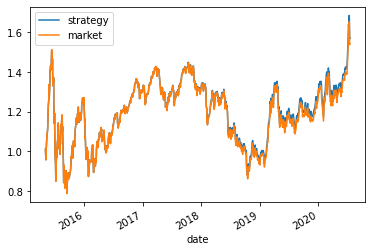

In [208]:
default_index = X.index[y==1]
actual_default = data.loc[default_index, ['stockcode', 'report_period']]
result = backtest(actual_default)

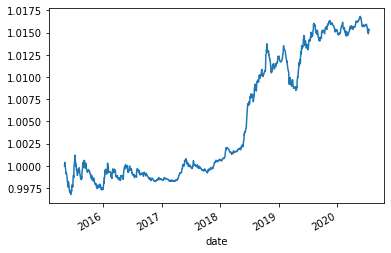

In [209]:
((result[0]-result[1])+1).cumprod().plot()

In [234]:
((result[0]-result[1])+1).cumprod().iloc[-1]

1.0153336169293676

strategy    1.658754
market      1.540941
Name: 2020-07-17 00:00:00, dtype: float64
difference sharpe:  0.08478446629135535


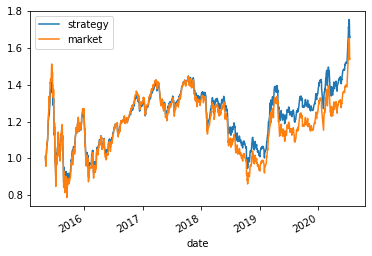

In [206]:
rf_predict = get_predict(rf_gs, X, rf_thre)
result = backtest(rf_predict)

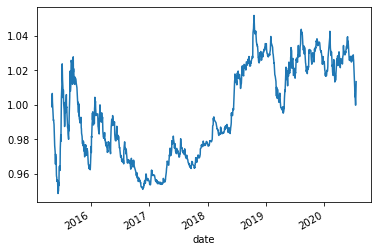

In [207]:
((result[0]-result[1])+1).cumprod().plot()

strategy    1.291560
market      1.274234
Name: 2020-07-17 00:00:00, dtype: float64
difference sharpe:  0.08424256740166286


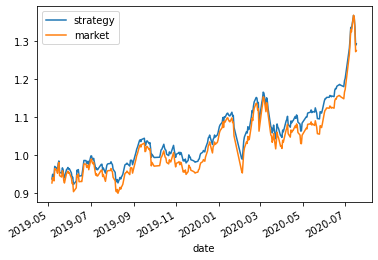

In [205]:
rf_predict = get_predict(rf_gs, X_test, rf_thre)
result = backtest(rf_predict)

In [233]:
1.73**(1/1.3)

1.5244472002434521

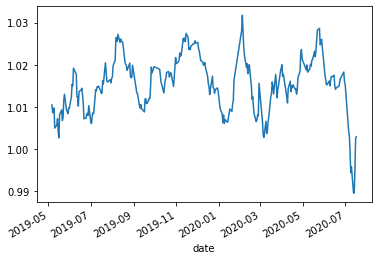

In [201]:
((result[0]-result[1])+1).cumprod().plot()